In [1]:
import os
import re
import pandas as pd
import numpy as np
from natsort import natsorted, index_natsorted, order_by_index

part_pattern = "(^|ст(\.|))\s*\d{3}(\.\d{1}|)(\s*ч*\.*\s*\d{1}|)(\s*\.\d{1}|)"

def dropFirstRows(df, value2search, rowsNum = None):
    """
    Функция находит строку первого столбца в таблице, значение которой соответствует параметру value2search,
    и удаляет количество строк, указанное в параметре rowsNum.
    Если rowsNum не задан - удаляются все строки начиная с самой верхней.
    """
    for index, val in df.iloc[:,0].str.contains(value2search).iteritems():
        if val == True and val != np.nan and index !=0:
            if rowsNum is None:
                df.drop(df.index[0:index], inplace=True)
            else:
                df.drop(df.index[index-rowsNum:index], inplace=True)
                break
            df.reset_index(drop=True, inplace=True)
    return df

def cutNumbers(string):
    '''Служебная функция нужная, чтобы при склеивании строк в tackleMergedCells вырезать строки, содержащие только числа'''
    string = str(string)
    string = string.replace("nan", "")
    match = re.search(r'(^\d+$)', string)
    if match:
        string = string.replace(match.group(), "")
    return string



def deleteUnusedCols(df, year):
    """
    Удаляет пустые колонки, а также неиспользуемые нами колонки
    """
    df.dropna(axis='columns', how='all', inplace=True) # удаляем пустые колонки
    df.columns = pd.Series(df.iloc[0,]).astype('str') # превращаем первую строку в заголовок таблицы
    df = cleanСolsNames(df)

    indeces2remove = []

    # находим номер колонки, в которой содержится ненужный нам номер строки или пункта, если они попали в заголовок таблицы
    i = -1
    for col in df.columns:
        i += 1
        if col.find('№') > -1:
            indeces2remove.append(i)
            break
    # или находим номер колонки, в которой содержится ненужный нам номер строки или пункта, если они не попали в заголовок и отличаются от других колонок двумя строками с NA
    header_rows = 3
    j = -1
    for index, col in df.iloc[0:header_rows].iteritems():
        j += 1
        if col.isnull().values.all():
            indeces2remove.append(j)

    # удаляем колонку с найденным индексом
    column_numbers = [x for x in range(df.shape[1])]  # list of columns' integer indices
    for index in indeces2remove:
        column_numbers.remove(index) #removing column integer index i
    df = df.iloc[:, column_numbers]
    df.columns = range(df.shape[1])
    return df

def cleanСolsNames(df):
    '''Очищает заголовок таблицы символов перевода строки, двоеточий, переводит заглавные буквы в строчные'''
    df.columns = df.columns.str.strip()
    df.columns = df.columns.str.lower()
    df.columns = df.columns.str.replace("\n", "")
    df.columns = df.columns.str.replace(":", "")
    return df

def renameColumns(df, column_mapping):
    rename_dict = dict(zip(column_mapping['original'], column_mapping['translation']))
    df.rename(columns=rename_dict, inplace=True)
    # проверяем, что все колонки переименовались
    print('Проверяем, что все переименовано.\nЕсли ничего не печатается, то все переименовано.\nЕсли остались не переименованные колонки, это иногда ок: мы не используем колонки, значения в которых легко вычисляются сложнением других колонок или повторяются в других файлах')
    for column in df.columns:
        if re.search(r'[а-яА-Я]', str(column)):
            print(column)
    return df

def dropNARows(df):
    df.drop(df.index[0:1], inplace=True)
    df.dropna(axis='rows', how='any', inplace=True)
    return df

def deleteUselessRows(df, year):
    '''Удаляем строки, в которых нет информации о конкретных статьях'''
    df['clause'] = df['clause'].astype(str)
    if 'name' in df.columns:
        df = df[~df['name'].str.contains('ВСЕГО|ИТОГО')]
    df = df.reset_index(drop=True)
    return df

def insertEmptyRows(df, year, clauses2Insert):
    '''Поскольку в 2012 и 2015 годах встречаются строки, в которых собраны несколько статей, все значения по которым равны
    нулю, т.е. не было ни осужденных, ни прекращенных дел, ни оправданных и т.д., то такие строки можно разбить по статьям
    '''
    year = str(year)
    dict2Insert = {}
    if year in clauses2Insert.keys():
        for clause in clauses2Insert[year]:
            for col in df.columns:
                dict2Insert[col] = [0]
            dict2Insert['clause'] = clause
            df2Insert = pd.DataFrame.from_dict(dict2Insert)
            df_concat = pd.concat([df, df2Insert], sort=True)
            df = df_concat.reset_index(drop=True)
    return df

def cleanClauseCol(df):
    df['clause'] = df['clause'].str.replace("Составы преступлений, введенные в УК РФ после утверждения форм отчетности:\nКлевета \(введ. ФЗ от 28.07.2012 N 141-ФЗ\) ст. ", "")
    df['clause'] = df['clause'].str.replace("Составы преступлений, введенные в раздел IX \"Преступления против общественной безопасности и общественного порядка\" УК РФ после утверждения форм отчетности приказом № 127\s+ст. ", "")
    df['clause'] = df['clause'].str.replace("Клевета в отношении судьи, присяжного заседателя, прокурора, следователя, лица, производящего дознание, судебного пристава \(введ. ФЗ от 28.07.2012 N 141-ФЗ\)\s+ст. ", "")

    df['clause'] = df['clause'].str.replace('Мошенничество, совершенное в сфере кредитования; при получении выплат; с использованием платежных карт; в сфере предпринимательской деят-ти; в сфере страхования; в сфере компьютерной информации \(введ. ФЗ от 29.11.2012 N 207-ФЗ\) ст\. ', '')

    df['clause'] = df['clause'].astype("str")
    df['clause'] = df['clause'].str.replace(" ", "")
    df['clause'] = df['clause'].str.replace("-", ".")
    df['clause'] = df['clause'].str.replace("ст(\.|)", "")
    df['clause'] = df['clause'].str.replace("\.ч", "ч")

    df['clause'] = df['clause'].str.replace("207\(.+\),", "")
    return df

def clauses2column(df):
    # создаем колонку part с номером статьи и части без примечаний и удаляем из нее лишние пробелы
    # df['clause'] = df['clause'].str.replace("\.\s*ч", "ч")
    # df['part'] = df.apply(lambda row: re.search(part_pattern, row['clause']).group(), axis=1)
    # на случай, если все-таки захочется вернуть воинские преступления
    df['part'] = df.apply(lambda row: re.search(part_pattern, row['clause']).group() if re.search(r'[Вв]оинск', row['clause']) is None else "Воинские преступления", axis=1)
    df['part'] = df['part'].str.replace("^ст\.\s", "")
    df['part'] = df['part'].str.replace(" ", "")
    # тут мы отрезаем номер статьи от примечаний типа "в старой редакции" - может пригодиться для целей сверки таблиц, но в целом нет
    '''
    df['clause'] = df.apply(lambda row: row['clause'].replace(re.search(part_pattern, row['clause']).group(), ""), axis=1)
    df['clause'] = df['clause'].str.replace("\sст. $", "")
    df['clause'] = df['clause'].str.replace("^\s", "")
    # колонку clause переименовываем в comments
    df.rename(index=str, columns={"clause": "comments"}, inplace=True)
    '''
    # в колонку clause складываем статьи без частей, используя ранее созданную колонку part
    df['clause'] = df.apply(lambda row: re.search(r'(\d{3}(\.\d{1}|))', row['part']).group() if re.search(r'[Вв]оинск', row['clause']) is None else "Воинские преступления", axis=1)
    #df['clause'] = df.apply(lambda row: re.search(r'(\d{3}(\.\d{1}|))', row['part']).group(), axis=1)
    df.replace("Воинскиепреступления", "Воинские преступления", inplace=True)
    return df

def addMilitaryOfences(df):
    df = pd.concat([df, pd.DataFrame([[np.nan] * df.shape[1]], columns=df.columns)], ignore_index=True)
    ind = np.where(df['name'].isna())[0][0]
    df.at[ind, 'name'] = "Воинские преступления"
    df.at[ind, 'clause'] = "Воинские преступления"
    df.at[ind, 'part'] = "Воинские преступления"
    return df

def rearrangeCols(df, firstCols):
    cols = firstCols  + [col for col in df.columns.tolist() if col not in firstCols]
    df = df[cols]
    return df

def sortTable(df):
    '''Сортирует таблицу по колонке part - со статьей и часть методом натуральной сортировки'''
    df = df.reindex(index=order_by_index(df.index, index_natsorted(df['part'])))
    df = df.reset_index(drop=True)
    return df

def tackleMergedCells(df):
    df.iloc[0:1].fillna(method='ffill', axis='columns', inplace=True)
    df.iloc[0:3].replace(to_replace=['\n', '-', '\*', '\s{3}', '\s{2}'],value=[' ', '', '', ' ', ' '], regex=True, inplace=True)
    for i in range(2, len(df.iloc[0])): # 2 - это номер колонки, с которой начинается смерживание объединенных колонок
        df.at[0, i] = str(df.iloc[0][i]).replace("nan", "") + " " + cutNumbers(df.iloc[1][i]) + " " + cutNumbers(df.iloc[2][i])

    df.columns = pd.Series(df.iloc[0,]).str.strip()
    df.reset_index(drop=True, inplace=True)
    return df

def nameSeparatedRows(df, names):
    for key in names.keys():
        ind = df.index[df['part'] == key].tolist()
        if len(ind) == 1:
            df.at[ind[0], 'name'] = names[key]
    return df

def meltTable(df, year):
    '''Приводит таблицу в длинную форму'''
    df.insert(0, 'year', [year]*len(df))
    df = pd.melt(df, id_vars=['year', 'clause', 'part', 'name'], value_vars = list(df.columns)[4:], var_name='parameter', value_name='value')
    return df

# Проверочные функции

def checkTablesLen(main, add, parameters = None):
    if parameters is not None:
        if len(main) != len(parameters):
            print("Не ОК: длины таблиц № 10.3 и № 10.3.1 не совпадают")
        else:
            print("ОК: длины таблиц № 10.3 и № 10.3.1 совпадают")
    if len(main) != len(add):
        print("Не ОК: длины таблиц № 10.3 и № 10-а не совпадают")
    else:
        print("ОК: длины таблиц № 10.3 и № 10-а совпадают")

def checkNumbersBetweenForms(year, mainDF, addDF, parametersDF = None):
    if year > 2010:
        for i in range(len(mainDF)):
            if mainDF.iloc[i]['part'] != parametersDF.iloc[i]['part']:
                print(i, "main", mainDF.iloc[i]['part'], "parameters", parametersDF.iloc[i]['part'])

            imprisonment_sum = parametersDF.iloc[i]['primaryImprisonment1'] + \
                                                         parametersDF.iloc[i]['primaryImprisonment1_2'] + \
                                                         parametersDF.iloc[i]['primaryImprisonment2_3'] + \
                                                         parametersDF.iloc[i]['primaryImprisonment3_5'] +\
                                                         parametersDF.iloc[i]['primaryImprisonment5_8'] +\
                                                         parametersDF.iloc[i]['primaryImprisonment8_10'] +\
                                                         parametersDF.iloc[i]['primaryImprisonment10_15'] +\
                                                         parametersDF.iloc[i]['primaryImprisonment15_20']
            if mainDF.iloc[i]['primaryImprisonment'] != imprisonment_sum:
                print("Не совпадает число осужденных к лишению свободы.", "\nСтатья: ", mainDF.iloc[i]['part'], "\n10.3", "Лишение свободы всего: ", mainDF.iloc[i]['primaryImprisonment'],
                      "\n10.3.1", "Лишение свободы сумма: ", imprisonment_sum)

            if mainDF.iloc[i]['part'] != addDF.iloc[i]['part']:
                print("Не совпадают номера статей. 10.3:", mainDF.iloc[i]['part'], "10-a:", addDF.iloc[i]['part'], "Год: ", year)
            if mainDF.iloc[i]['totalConvicted'] != addDF.iloc[i]['totalConvictedMain']:
                print("Не совпадает число осужденных по основной статье.", "\nСтатья: ", mainDF.iloc[i]['part'], "\n10.3:", mainDF.iloc[i]['totalConvicted'], "\n10-a:", addDF.iloc[i]['totalConvictedMain'], "\nГод:", year)
    else:
        for i in range(len(mainDF)):
            if mainDF.iloc[i]['part'] != addDF.iloc[i]['part']:
                print("Не совпадают номера статей. 10.3:", mainDF.iloc[i]['part'], "10-a:", addDF.iloc[i]['part'], "Год: ", year)
            if mainDF.iloc[i]['totalConvicted'] != addDF.iloc[i]['totalConvictedMain']:
                print("Не совпадает число осужденных по основной статье.", "\nСтатья: ", mainDF.iloc[i]['part'], "\n10.3:", mainDF.iloc[i]['totalConvicted'], "\n10-a:", addDF.iloc[i]['totalConvictedMain'], "\nГод:", year)

def compareSums(df, columns, total_values, start):
    columns = list(columns)[start:]
    cols = [col for col in columns if not re.search(r'[а-яА-Я]', col)]
    values2remove = []
    for col in columns:
        match = re.search(r'[а-яА-Я]{2,}', col)
        if match:
            ind = columns.index(col)
            values2remove.append(total_values[ind])
    values = [val for val in total_values if val not in values2remove]
    total_values = values
    DFreordered = df[cols]
    sums = DFreordered.sum(axis='index')
#     print(sums)
    if len(total_values) != len(sums):
        print("Количество колонок не совпадает")
    for i in range(0, len(total_values)):
        if total_values[i] != sums[i]:
            print('\nСумма значений в колонке', DFreordered.columns[i], sums[i], '\n', 'Значение в строке "Всего по составам УК РФ" ', total_values[i])

In [2]:
import os
import re
import pandas as pd
import numpy as np
from natsort import natsorted, index_natsorted, order_by_index

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 1000)

import warnings
warnings.filterwarnings('ignore')

In [3]:
year = 2021

## Обработка файлов формы № 10.3

In [4]:
file_path = "ExcelFiles/Main/10.3-svod-2021.xls"

mainDF = pd.read_excel(file_path, sheet_name=1)

In [5]:
mainDF = dropFirstRows(mainDF, 'Статьи УК РФ')

In [6]:
mainDF = deleteUnusedCols(mainDF, year)

In [7]:
#mainDF.head(6)

In [8]:
total_values = list(mainDF[mainDF.iloc[:,0].astype('str').str.contains("Всего по составам УК РФ|Всего лиц по составам УК РФ")].values[0][1:])

In [9]:
mainDF = dropFirstRows(mainDF, '105 ч. 1|105 ч.1|105ч. 1', 2)

In [10]:
#mainDF.head()

In [11]:
mainDF.iloc[1][16] = mainDF.iloc[1][15]
mainDF.iloc[1][18] = mainDF.iloc[1][17]
mainDF.iloc[1][20] = mainDF.iloc[1][19]
mainDF = tackleMergedCells(mainDF)

In [12]:
#mainDF.head()

In [13]:
mainDF = cleanСolsNames(mainDF)

In [14]:
#mainDF.head()

In [15]:
columns = mainDF.columns # эта строка тоже будет нужна позже для проверки
columns2eng = pd.read_csv('translations/2021/colNames2engNames_2021.csv')
mainDF = renameColumns(mainDF, columns2eng)

Проверяем, что все переименовано.
Если ничего не печатается, то все переименовано.
Если остались не переименованные колонки, это иногда ок: мы не используем колонки, значения в которых легко вычисляются сложнением других колонок или повторяются в других файлах


In [16]:
# mainDF.head()

In [17]:
mainDF = dropNARows(mainDF)

In [18]:
# mainDF.tail()

In [19]:
mainDF = deleteUselessRows(mainDF, year)

In [20]:
#mainDF.tail()

In [21]:
remove_rows_with_text = [
    "Составы преступлений, введенные в УК РФ в 2021 году",
   "Составы преступлений, введенные в УК РФ в 2021 году: 171.5; 195 ч. 1.1; 195 ч. 2.1; 195 ч. 4; 195 ч. 5; 196 ч. 2",
    "284.1 ч. 2; 284.1 ч. 3",
]
for text in remove_rows_with_text:
  mainDF = mainDF[~mainDF['clause'].str.contains(text)]

In [22]:
clauses2Insert = {'2021': [
    # эти статьи были склеены, но по ним ноль осужденных, так что можно их просто расклеить и везде вписать нули
    '171.5',
    '195 ч. 1.1',
    '195 ч. 2.1',
    '195 ч. 4',
    '195 ч. 5',
    '196 ч. 2',
    '284.1 ч. 2',
    '284.1 ч. 3',

   '222.1 ч. 4',
   '222.1 ч. 5',
   '222.1 ч. 6',
    ]}

mainDF = insertEmptyRows(mainDF, year, clauses2Insert)

In [23]:
clause222 = '222,222.1,222.2'
part222 =  '222 ч. 5; 222 ч. 6; 222 ч. 7; 222.2 ч. 1; 222.2 ч. 2; 222.2 ч. 3; 222.2 ч. 4; 222.2 ч. 5; 222.2 ч. 6'

In [24]:
ind = mainDF.index[mainDF['clause'] == '222 ч. 5; 222 ч. 6; 222 ч. 7; 222.1 ч. 4; 222.1 ч. 5; 222.1 ч. 6; 222.2 ч. 1; 222.2 ч. 2; 222.2 ч. 3; 222.2 ч. 4; 222.2 ч. 5; 222.2 ч. 6'][0]

In [25]:
mainDF = cleanClauseCol(mainDF) # чистим колонку с номерами статей от лишнего текста
mainDF = clauses2column(mainDF) # используя регулярное выражение, создаем колонки со номерами статей и частей

In [26]:
# подправляем те строки, которые должны остаться склеенными
mainDF.at[ind, 'clause'] = clause222
mainDF.at[ind, 'part'] = part222

Для проверки, что никакие цифры не потерялись, можно посчитать суммы по столбцам и выборочно сверить с исходной таблицей.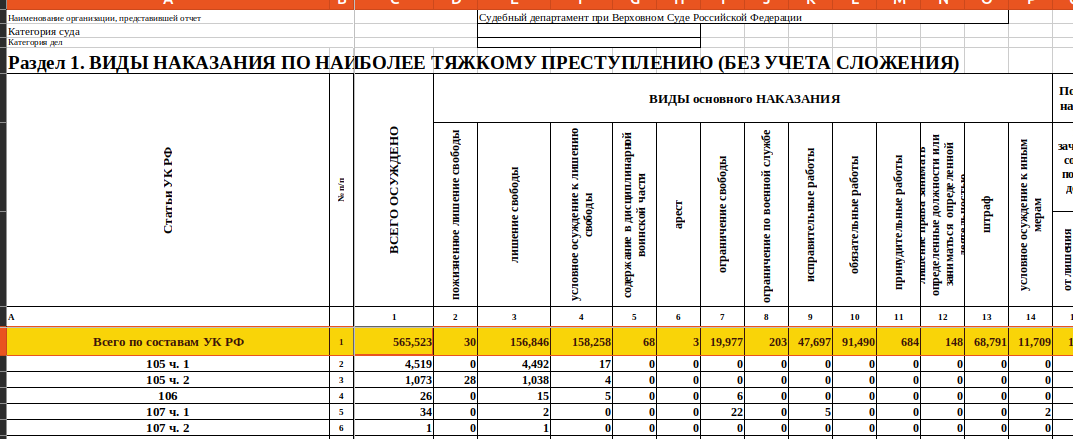

In [27]:
mainDF.sum(axis=0)

acquittal                                                                             1147
addDisqualification                                                                  59115
addFine                                                                               5418
addRestrain                                                                           5640
addTitlesWithdraw                                                                      167
clause                                   105105106107107108108109109109110110110.1110.1...
coerciveMeasures                                                                      7642
dismissalAbsenceOfEvent                                                               1172
dismissalAmnesty                                                                        22
dismissalCourtFine                                                                   36685
dismissalOther                                                                       12002

In [28]:
firstCols = ['clause', 'part', 'totalConvicted']
mainDF = rearrangeCols(mainDF, firstCols) # меняем порядок столбцов для удобства
mainDF = sortTable(mainDF) # упорядочиваем строки

## Обработка файлов формы № 10.3.1

In [29]:
parametersFile = 'ExcelFiles/MainParameters/10.3.1-svod-2021.xls'
parametersDF = pd.read_excel(parametersFile, 1, header=None)

total_values = list(parametersDF[parametersDF.iloc[:,0].astype('str').str.contains("Всего по составам УК РФ|Всего лиц по составам УК РФ")].values[0][3:])

parametersDF = dropFirstRows(parametersDF, 'Статьи УК РФ')
parametersDF = deleteUnusedCols(parametersDF, year)
parametersDF = dropFirstRows(parametersDF, '105 ч. 1|105 ч.1|105ч. 1', 2)

parametersDF = tackleMergedCells(parametersDF)

parametersDF = cleanСolsNames(parametersDF)
columns2eng = pd.read_csv('translations/2021/colNames2engNamesParameters_2021.csv')
parametersDF = renameColumns(parametersDF, columns2eng)

columns = parametersDF.columns

parametersDF = parametersDF[parametersDF.columns[~parametersDF.columns.str.contains('[а-яА-Я]{2,}', regex=True)]]
parametersDF = dropNARows(parametersDF)
parametersDF = deleteUselessRows(parametersDF, year)

remove_rows_with_text = [
    "Составы преступлений, введенные в УК РФ в 2021 году",
   "Составы преступлений, введенные в УК РФ в 2021 году: 171.5; 195 ч. 1.1; 195 ч. 2.1; 195 ч. 4; 195 ч. 5; 196 ч. 2",
    "284.1 ч. 2; 284.1 ч. 3",
]
for text in remove_rows_with_text:
  parametersDF = parametersDF[~parametersDF['clause'].str.contains(text)]

clauses2Insert = {'2021': ['171.5',
'195 ч. 1.1',
'195 ч. 2.1',
'195 ч. 4',
'195 ч. 5',
'196 ч. 2',
'284.1 ч. 2',
'284.1 ч. 3',

'222.1 ч. 4',
'222.1 ч. 5',
'222.1 ч. 6']}


parametersDF = insertEmptyRows(parametersDF, year, clauses2Insert)

ind = parametersDF.index[parametersDF['clause'] == '222 ч. 5; 222 ч. 6; 222 ч. 7; 222.1 ч. 4; 222.1 ч. 5; 222.1 ч. 6; 222.2 ч. 1; 222.2 ч. 2; 222.2 ч. 3; 222.2 ч. 4; 222.2 ч. 5; 222.2 ч. 6'][0]

parametersDF = cleanClauseCol(parametersDF)
parametersDF = clauses2column(parametersDF)

parametersDF.at[ind, 'clause'] = clause222
parametersDF.at[ind, 'part'] = part222

firstCols = ['clause', 'part']
parametersDF = rearrangeCols(parametersDF, firstCols)
parametersDF = sortTable(parametersDF)

Проверяем, что все переименовано.
Если ничего не печатается, то все переименовано.
Если остались не переименованные колонки, это иногда ок: мы не используем колонки, значения в которых легко вычисляются сложнением других колонок или повторяются в других файлах
лишение свободы всего (число лиц)
общая сумма штрафов (из гр. 13 "основное наказание" ф. 10.3) всего лиц
общая сумма штрафов (из гр. 28 "дополнительное наказание" ф. 10.3) всего лиц
общая сумма судебных штрафов, назначенных в соответствии со статьей 104.4 ук рф всего лиц


In [30]:
parametersDF

clause                                               part  \
0                      105                                             105ч.1   
1                      105                                             105ч.2   
2                      106                                                106   
3                      107                                             107ч.1   
4                      107                                             107ч.2   
5                      108                                             108ч.1   
6                      108                                             108ч.2   
7                      109                                             109ч.1   
8                      109                                             109ч.2   
9                      109                                             109ч.3   
10                   110.1                                           110.1ч.1   
11                   110.1                                           110.1ч.2   
12                   110.1                                           110.1ч.3   
13                   110.1                                           110.1ч.4   
14                   110.1                                           110.1ч.5   
15                   110.1                                           110.1ч.6   
16                   110.2                                           110.2ч.1   
17                   110.2                                           110.2ч.2   
18                     110                                             110ч.1   
19                     110                                             110ч.2   
20                     111                                             111ч.1   
21                     111                                             111ч.2   
22                     111                                             111ч.3   
23                     111                                             111ч.4   
24                     112                                             112ч.1   
25                     112                                             112ч.2   
26                     113                                                113   
27                     114                                             114ч.1   
28                     114                                             114ч.2   
29                     115                                             115ч.1   
30                     115                                             115ч.2   
31                     116                                                116   
32                   116.1                                              116.1   
33                     116                                             116ч.1   
34                     116                                             116ч.2   
35                     117                                             117ч.1   
36                     117                                             117ч.2   
37                     118                                             118ч.1   
38                     118                                             118ч.2   
39                     118                                             118ч.3   
40                     118                                             118ч.4   
41                     119                                             119ч.1   
42                     119                                             119ч.2   
43                     120                                             120ч.1   
44                     120                                             120ч.2   
45                     121                                             121ч.1   
46                     121                                             121ч.2   
47                     122                                             122ч.1   
48                     122                         

In [31]:
compareSums(parametersDF, columns, total_values, 2)


Сумма значений в колонке dismissalCourtFine5 9767 
 Значение в строке "Всего по составам УК РФ"  9771

Сумма значений в колонке dismissalCourtFine5_25 22273 
 Значение в строке "Всего по составам УК РФ"  22274

Сумма значений в колонке dismissalCourtFine100 323 
 Значение в строке "Всего по составам УК РФ"  322


In [32]:
parametersDF.sum(axis=0)

clause                                105105106107107108108109109109110.1110.1110.11...
part                                  105ч.1105ч.2106107ч.1107ч.2108ч.1108ч.2109ч.11...
addFine100_300                                                                      797
addFine1M                                                                           160
addFine25_100                                                                      1937
addFine300_500                                                                      301
addFine5                                                                            688
addFine500_1M                                                                       213
addFine5_25                                                                        1322
addFineSum                                                                   2934102199
dismissalCourtFine100                                                               323
dismissalCourtFine25_100        

## Обработка файлов формы № 10-а

In [33]:
addFile = 'ExcelFiles/Add/10-a-svod-2021.xls'

df_list = pd.read_excel(addFile, sheet_name=None, header = None)
dfs = []
for key in list(df_list.keys())[2:-1]:
    df = df_list[key]
    df = dropFirstRows(df, 'Виды преступлений')
    df = dropFirstRows(df, '[а-яА-Я]{3,}', 1)
    df = deleteUnusedCols(df, year)
    df = tackleMergedCells(df)
    columns2eng = pd.read_csv('translations/2021/colNames2engNamesAdd_2021.csv')
    df = renameColumns(df, columns2eng) # тут заголовок таблицы предварительно чистить не надо

    df = df[df.columns[~df.columns.str.contains('[а-яА-Я]{2,}', regex=True)]]
    df = dropNARows(df)
    dfs.append(df)
    addDF = pd.concat(dfs, ignore_index=True)


Проверяем, что все переименовано.
Если ничего не печатается, то все переименовано.
Если остались не переименованные колонки, это иногда ок: мы не используем колонки, значения в которых легко вычисляются сложнением других колонок или повторяются в других файлах
Число оправданных по основной статье
Число лиц, в отношении которых уголовные дела прекращены за отсутствием состава, события преступления, непричастностью к преступлению по основной статье
Число лиц, в отношении которых уголовные дела прекращены по иным основаниям по основной статье
Принудительные меры медицинского характера в отношении невменяемого Число лиц по основной статье
Проверяем, что все переименовано.
Если ничего не печатается, то все переименовано.
Если остались не переименованные колонки, это иногда ок: мы не используем колонки, значения в которых легко вычисляются сложнением других колонок или повторяются в других файлах
Число оправданных по основной статье
Число лиц, в отношении которых уголовные дела прекращены за

In [34]:
addDF.clause = addDF.clause.astype(str)

remove_rows_with_text = ["195 ч. 1.1; 195 ч. 2.1; 195 ч. 4; 195 ч. 5",
                         "222 ч. 5; 222 ч. 6; 222 ч. 7",
                         "222.1 ч. 4; 222.1 ч. 5; 222.1 ч. 6",
                         "222.2 ч. 1; 222.2 ч. 2; 222.2 ч. 3; 222.2 ч. 4; 222.2 ч. 5; 222.2 ч. 6",
                         "284.1 ч. 2; 284.1 ч. 3"]
for text in remove_rows_with_text:
  addDF = addDF[~addDF['clause'].str.contains(text)]

In [35]:
clauses2Insert = {'2021': [
'195ч.1.1',
'195ч.2.1',
'195ч.4',
'195ч.5',

'284.1ч.2',
'284.1ч.3',

'222.1ч.4',
'222.1ч.5',
'222.1ч.6',
clause222
     ]}
addDF = insertEmptyRows(addDF, year, clauses2Insert)


ind = addDF.index[addDF['clause'] == clause222][0]
addDF.at[ind, 'totalConvictedMain'] = 22
addDF.at[ind, 'addTotalPersons'] = 1
addDF.at[ind, 'addTotalOffences'] = 1

addDF = cleanClauseCol(addDF)
addDF = clauses2column(addDF)
addDF = addMilitaryOfences(addDF)

addDF.at[ind, 'clause'] = clause222
addDF.at[ind, 'part'] = part222
addDF.at[ind, 'name'] = np.nan


names = {'171.5': 'Незаконное осуществление деятельности по предоставлению потребительских кредитов (займов)',
         '195ч.1.1': 'Те же деяния, совершенные лицом с использованием своего служебного положения, а равно контролирующим должника лицом либо руководителем этого контролирующего лица',
         '195ч.2.1': 'Деяние, предусмотренное частью второй настоящей статьи, совершенное арбитражным управляющим или председателем ликвидационной комиссии (ликвидатором), а равно контролирующим должника лицом либо руководителем этого контролирующего лица',
         '195ч.4': 'Деяние, предусмотренное частью третьей настоящей статьи, совершенное лицом с использованием своего служебного положения, а равно контролирующим должника лицом либо руководителем этого контролирующего лица',
         '195ч.5': 'Деяния, предусмотренные частями первой - четвертой настоящей статьи, совершенные группой лиц по предварительному сговору или организованной группой',
         '196ч.2': 'То же деяние, совершенное: а) лицом с использованием своего служебного положения или контролирующим должника лицом либо руководителем этого контролирующего лица; б) группой лиц по предварительному сговору или организованной группой',
         '222.1ч.4': 'Деяния, предусмотренные частью первой настоящей статьи, совершенные организованной группой',
         '222.1ч.5': 'Деяние, предусмотренное частью второй настоящей статьи, совершенное: а) группой лиц по предварительному сговору; б) лицом с использованием своего служебного положения; в) с использованием информационно-телекоммуникационных сетей, в том числе сети "Интернет"',
         '222.1ч.6': 'Деяние, предусмотренное частью второй настоящей статьи, совершенное организованной группой',
         '264.1ч.2': 'Управление автомобилем, трамваем либо другим механическим транспортным средством лицом, находящимся в состоянии опьянения, имеющим судимость за совершение в состоянии опьянения преступления, предусмотренного частями второй, четвертой или шестой статьи 264 настоящего Кодекса либо настоящей статьей',
         '284.1ч.2': 'Предоставление или сбор средств либо оказание финансовых услуг, заведомо предназначенных для обеспечения деятельности иностранной или международной организации, в отношении которой принято решение о признании нежелательной на территории Российской Федерации ее деятельности в соответствии с законодательством Российской Федерации',
         '284.1ч.3': 'Организация деятельности иностранной или международной организации, в отношении которой принято решение о признании нежелательной на территории Российской Федерации ее деятельности в соответствии с законодательством Российской Федерации'
         }

addDF = nameSeparatedRows(addDF, names)

ind = addDF.index[addDF['part'] == '136'][0]
addDF.at[ind, 'part'] = '136ч.2'
addDF['part'] = addDF['part'].replace('168ч.1','168')


firstCols = ['name', 'clause', 'part', 'totalConvictedMain']
addDF = rearrangeCols(addDF, firstCols)
addDF = sortTable(addDF)

In [36]:
addDF

name                 clause  \
0                                             Убийство                    105   
1              Убийство при отягчающих обстоятельствах                    105   
2              Убийство матерью новорожденного ребенка                    106   
3            Убийство, совершенное в состоянии аффекта                    107   
4      Убийство в состоянии аффекта двух или более лиц                    107   
5    Убийство при превышении пределов необходимой о...                    108   
6    Убийство при превышении мер, необходимых для з...                    108   
7                  Причинение смерти по неосторожности                    109   
8    Причинение смерти по неосторожности при отягча...                    109   
9    Причинение смерти по неосторожности двум или б...                    109   
10   Склонение к совершению самоубийства или содейс...                  110.1   
11         Содействие совершению самоубийства советами                  110.1   
12   Деяния, предусмотренные частями первой или вто...                  110.1   
13   Деяния, предусмотренные частью первой или втор...                  110.1   
14   Деяния, предусмотренные частями первой или вто...                  110.1   
15   Деяния, предусмотренные частями первой, второй...                  110.1   
16   Организация деятельности, направленной на побу...                  110.2   
17   Организация деятельности, направленной на побу...                  110.2   
18                           Доведение до самоубийства                    110   
19   Доведение до самоубийства, совершенное при отя...                    110   
20        Умышленное причинение тяжкого вреда здоровью                    111   
21   Умышленное причинение тяжкого вреда здоровью п...                    111   
22   Умышленное причинение тяжкого вреда здоровью п...                    111   
23   Умышленное причинение тяжкого вреда здоровью, ...                    111   
24   Умышленное причинение средней тяжести вреда зд...                    112   
25   Умышленное причинение средней тяжести вреда зд...                    112   
26   Причинение тяжкого или средней тяжести вреда з...                    113   
27   Причинение тяжкого вреда здоровью при превышен...                    114   
28   Причинение тяжкого вреда здоровью при превышен...                    114   
29   Умышленное причинение легкого вреда здоровью (...                    115   
30   Умышленное причинение легкого вреда здоровью, ...                    115   
31                                              Побои                     116   
32   Нанесение побоев лицом, подвергнутым администр...                  116.1   
33   Побои (включая ст. 116 УК РФ (до редакции ФЗ о...                    116   
34        Побои, совершенные из хулиганских побуждений                    116   
35                                           Истязание                    117   
36            Истязание при отягчающих обстоятельствах                    117   
37   Причинение тяжкого вреда здоровью по неосторож...                    118   
38   Причинение тяжкого вреда здоровью по неосторож...                    118   
39   Причинение средней тяжести вреда здоровью по н...                    118   
40   Причинение тяжкого вреда здоровью по неосторож...                    118   
41   Угроза убийством или причинением тяжкого вреда...                    119   
42   Угроза убийством или причинением тяжкого вреда...                    119   
43   Принуждение к изъятию органов или тканей челов...                    120   
44   Принуждение к изъятию органов или тканей челов...                    120   
45                     Заражение венерической болезнью                    121   
46   Принуждение к изъятию органов или тканей челов...                    121   
47   Заведомое поставление лица в опасность заражен...                    122   
48                Заражение другого лица ВИЧ-инфекцией                    122   


In [37]:
checkTablesLen(mainDF, addDF, parametersDF)
checkTablesLen(mainDF, addDF)

ОК: длины таблиц № 10.3 и № 10.3.1 совпадают
ОК: длины таблиц № 10.3 и № 10-а совпадают
ОК: длины таблиц № 10.3 и № 10-а совпадают


In [38]:
checkNumbersBetweenForms(year, mainDF, addDF, parametersDF)

Не совпадает число осужденных к лишению свободы. 
Статья:  105ч.2 
10.3 Лишение свободы всего:  1038 
10.3.1 Лишение свободы сумма:  1037
Не совпадает число осужденных по основной статье. 
Статья:  Воинские преступления 
10.3: 1083 
10-a: nan 
Год: 2021


In [39]:
addDF = addDF.drop(['clause', 'part', 'totalConvictedMain'], axis=1)
parametersDF = parametersDF.drop(['clause', 'part'], axis=1)
df = pd.concat([mainDF, parametersDF, addDF], axis=1)

In [40]:
df

clause                                               part  \
0                      105                                             105ч.1   
1                      105                                             105ч.2   
2                      106                                                106   
3                      107                                             107ч.1   
4                      107                                             107ч.2   
5                      108                                             108ч.1   
6                      108                                             108ч.2   
7                      109                                             109ч.1   
8                      109                                             109ч.2   
9                      109                                             109ч.3   
10                   110.1                                           110.1ч.1   
11                   110.1                                           110.1ч.2   
12                   110.1                                           110.1ч.3   
13                   110.1                                           110.1ч.4   
14                   110.1                                           110.1ч.5   
15                   110.1                                           110.1ч.6   
16                   110.2                                           110.2ч.1   
17                   110.2                                           110.2ч.2   
18                     110                                             110ч.1   
19                     110                                             110ч.2   
20                     111                                             111ч.1   
21                     111                                             111ч.2   
22                     111                                             111ч.3   
23                     111                                             111ч.4   
24                     112                                             112ч.1   
25                     112                                             112ч.2   
26                     113                                                113   
27                     114                                             114ч.1   
28                     114                                             114ч.2   
29                     115                                             115ч.1   
30                     115                                             115ч.2   
31                     116                                                116   
32                   116.1                                              116.1   
33                     116                                             116ч.1   
34                     116                                             116ч.2   
35                     117                                             117ч.1   
36                     117                                             117ч.2   
37                     118                                             118ч.1   
38                     118                                             118ч.2   
39                     118                                             118ч.3   
40                     118                                             118ч.4   
41                     119                                             119ч.1   
42                     119                                             119ч.2   
43                     120                                             120ч.1   
44                     120                                             120ч.2   
45                     121                                             121ч.1   
46                     121                                             121ч.2   
47                     122                                             122ч.1   
48                     122                         

In [41]:
firstCols = ['name', 'clause', 'part', 'totalConvicted']
df = rearrangeCols(df, firstCols)

In [42]:
df.head()

name clause    part  \
0                                         Убийство    105  105ч.1   
1          Убийство при отягчающих обстоятельствах    105  105ч.2   
2          Убийство матерью новорожденного ребенка    106     106   
3        Убийство, совершенное в состоянии аффекта    107  107ч.1   
4  Убийство в состоянии аффекта двух или более лиц    107  107ч.2   

   totalConvicted  acquittal  addDisqualification  addFine  addRestrain  \
0            4519         37                    2        0          408   
1            1073         22                    1        0          699   
2              26          0                    0        0            0   
3              34          0                    0        0            0   
4               1          0                    0        0            0   

   addTitlesWithdraw  coerciveMeasures  dismissalAbsenceOfEvent  \
0                  2               367                        0   
1                  1                84                        0   
2                  0                 2                        0   
3                  0                 0                        1   
4                  0                 0                        0   

   dismissalAmnesty  dismissalCourtFine  dismissalOther  \
0                 0                   0             139   
1                 0                   0              31   
2                 0                   0               0   
3                 0                   1               2   
4                 0                   0               0   

   dismissalReconciliation  dismissalRepentance  dismissalRepentance2  \
0                        0                    0                     0   
1                        0                    0                     0   
2                        0                    0                     0   
3                        8                    0                     0   
4                        0                    0                     0   

   exemptionAmnestyFromImprisonment  exemptionAmnestyOther  \
0                                 0                      0   
1                                 0                      0   
2                                 0                      0   
3                                 0                      0   
4                                 0                      0   

   exemptionOtherGroundsFromImprisonment  exemptionOtherGroundsOther  \
0                                      7                           2   
1                                      2                           0   
2                                      0                           0   
3                                      0                           0   
4                                      0                           0   

   exemptionTimeServedFromImprisonment  exemptionTimeServedOther  \
0                                    1                         0   
1                                    1                         0   
2                                    0                         0   
3                                    1                         2   
4                                    0                         0   

   noCrimeNecessity  noCrimeOther  ...  primaryFine1M  primaryFine25_100  \
0                 0             0  ...              0                  0   
1                 0             0  ...              0                  0   
2                 0             0  ...              0                  0   
3                 0             0  ...              0                  0   
4                 0             0  ...              0                  0   

   primaryFine300_500  primaryFine5  primaryFine500_1M  primaryFine5_25  \
0                   0             0                  0                0   
1                   0             0                  0                0   
2                   0             0                  0                0   
3          

In [43]:
dfMelted = meltTable(df, year)

In [44]:
dfMelted.head()

year clause    part                                             name  \
0  2021    105  105ч.1                                         Убийство   
1  2021    105  105ч.2          Убийство при отягчающих обстоятельствах   
2  2021    106     106          Убийство матерью новорожденного ребенка   
3  2021    107  107ч.1        Убийство, совершенное в состоянии аффекта   
4  2021    107  107ч.2  Убийство в состоянии аффекта двух или более лиц   

        parameter value  
0  totalConvicted  4519  
1  totalConvicted  1073  
2  totalConvicted    26  
3  totalConvicted    34  
4  totalConvicted     1

In [45]:
dfMelted.to_pickle('2021.pkl')